### 1. Importing Libraries


In [1]:
import os
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import eda_helper_functions

from sklearn.ensemble import IsolationForest


In [2]:
### 2. Reading train data
df = pd.read_csv('../data/train.csv')
df.shape

(498, 8)

In [3]:
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,1,female,24.0,0,0,69.3000,C,1
1,3,female,3.0,3,1,21.0750,S,0
2,3,female,16.0,0,0,7.7333,Q,1
3,3,male,32.0,0,0,56.4958,S,1
4,3,male,22.0,0,0,7.1250,S,0


### 2. High Level Summary of Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    498 non-null    int64  
 1   sex       498 non-null    object 
 2   age       402 non-null    float64
 3   sibsp     498 non-null    int64  
 4   parch     498 non-null    int64  
 5   fare      498 non-null    float64
 6   embarked  497 non-null    object 
 7   survived  498 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 31.3+ KB


In [5]:
df.describe()

,pclass,age,sibsp,parch,fare,survived
count,498.000000,402.000000,498.000000,498.000000,498.000000,498.000000
mean,2.339357,29.309701,0.578313,0.381526,30.335199,0.379518
std,0.816885,14.646028,1.229619,0.799283,44.541796,0.485755
min,1.000000,0.670000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,0.000000,7.925000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.254150,0.000000
75%,3.000000,38.000000,1.000000,0.000000,30.053100,1.000000
max,3.000000,80.000000,8.000000,5.000000,512.329200,1.000000


none of the values r negative, so all look like valid values

In [6]:
df.describe(include='O')

,sex,embarked
count,498,497
unique,2,3
top,male,S
freq,333,373


`sex` and `embarked` are both imbalanced colms 

In [7]:
(
 df
 .assign(survived=df.survived.astype(object))
 .describe(include='O') 
)

,sex,embarked,survived
count,498,497,498
unique,2,3,2
top,male,S,0
freq,333,373,309


just experimenting above 

### 3. High level analysis of missing values in our dataset

In [8]:
df.isnull().sum()

pclass       0
sex          0
age         96
sibsp        0
parch        0
fare         0
embarked     1
survived     0
dtype: int64

In [9]:
eda_helper_functions.missing_info(df)

,count,percentage
variable,,
age,96,19.277108
embarked,1,0.200803


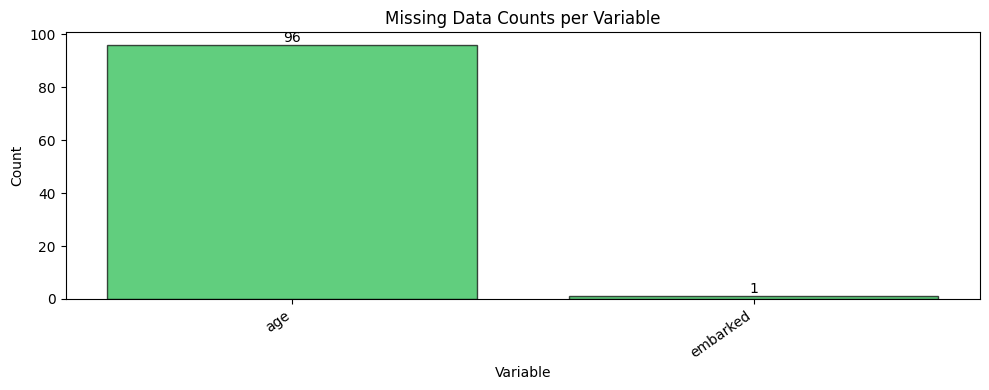

In [10]:
eda_helper_functions.plot_missing_info(df)

`age` and `embarked` have missing values

In [11]:
import missingno as msno


<Axes: >

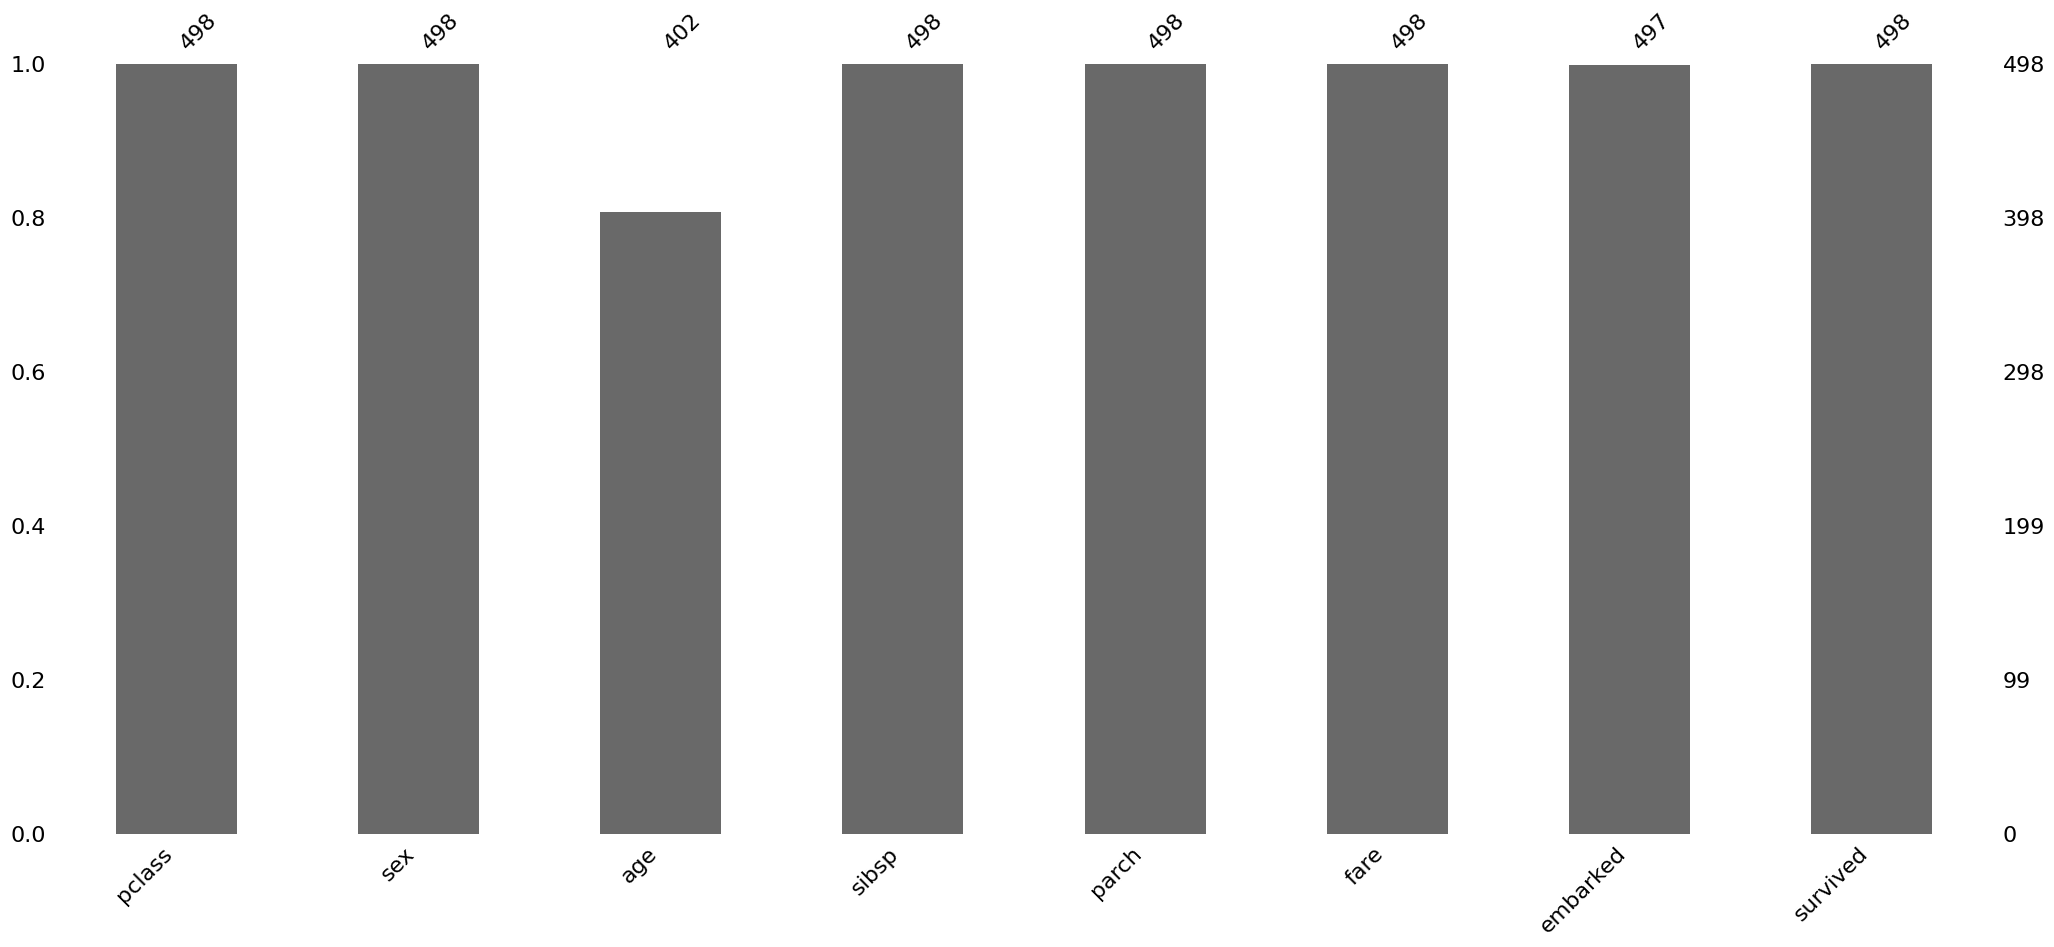

In [12]:
msno.bar(df)

<Axes: >

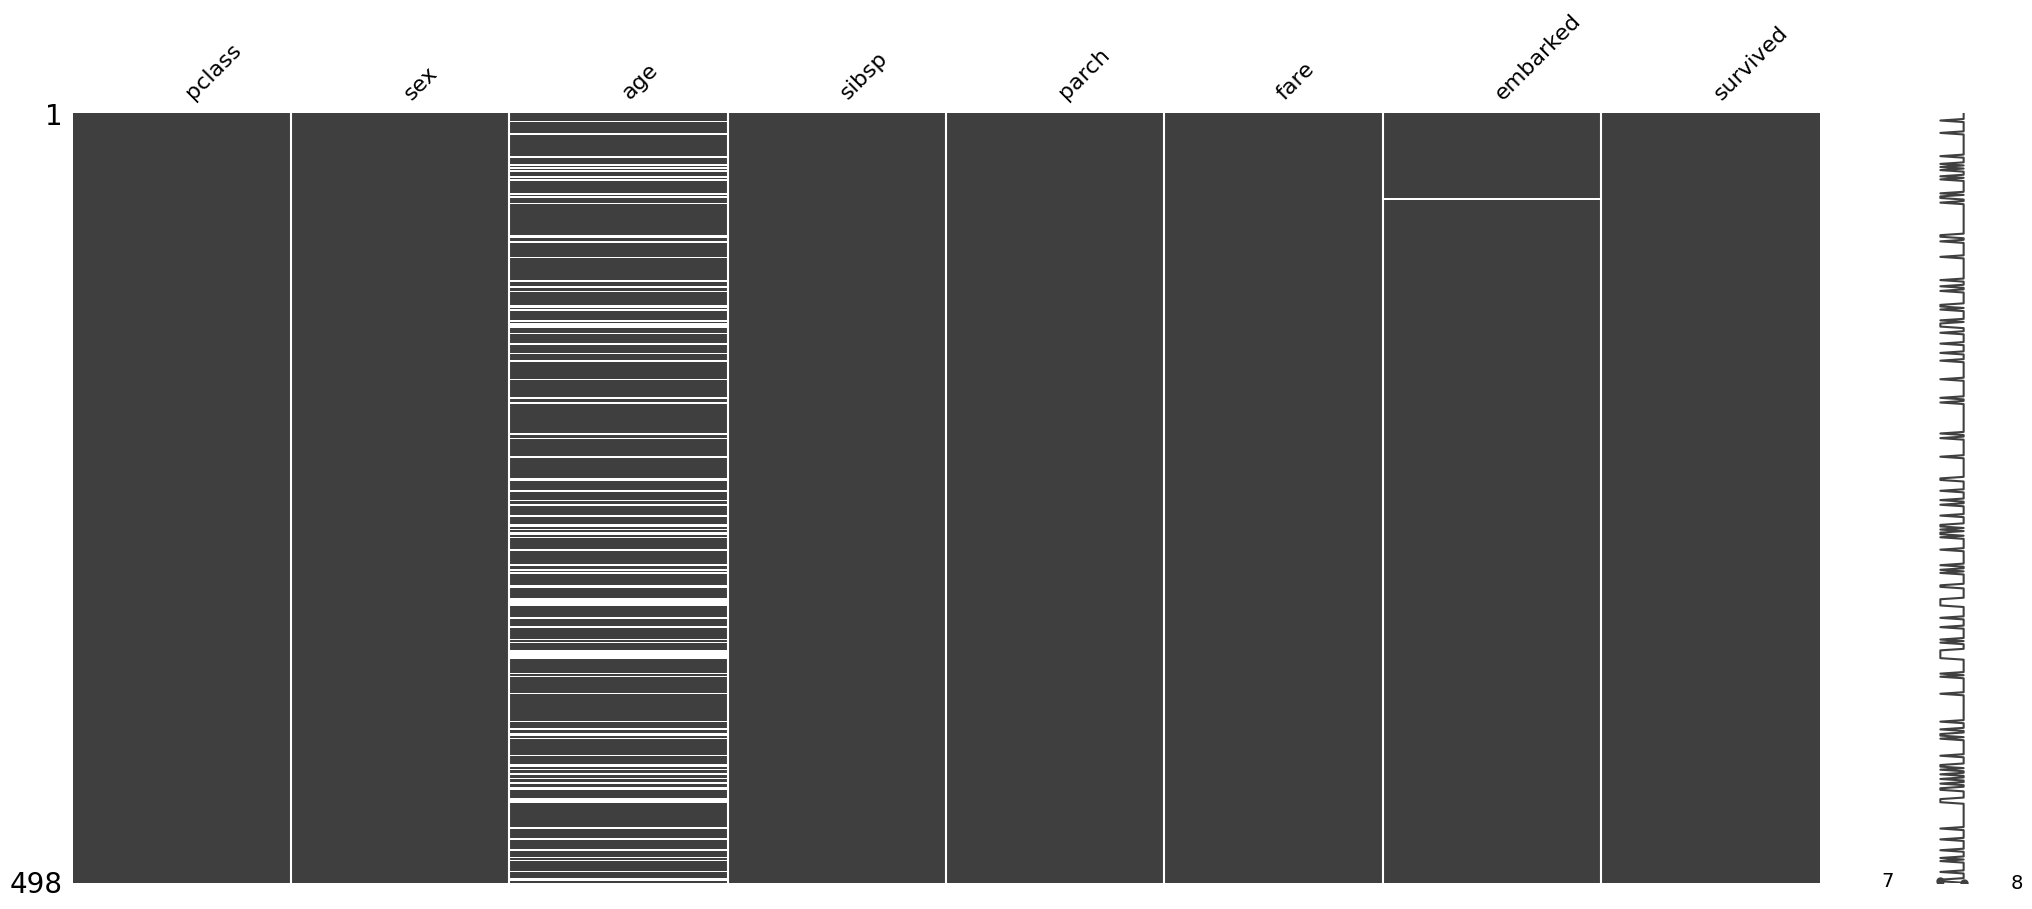

In [13]:
msno.matrix(df)

In [14]:
(
  df
  .assign(
    age_missing = lambda df_: df_.age.isnull().astype(int)
  )
  .groupby('pclass')
  .age_missing
  .mean()
)

pclass
1    0.109091
2    0.091743
3    0.265233
Name: age_missing, dtype: float64

3rd class passendgers have more missing values for `age` colm,
maybe coz they survived the least?  

In [15]:
(
  df
  .groupby('pclass')
  .survived
  .mean()
)

pclass
1    0.627273
2    0.449541
3    0.254480
Name: survived, dtype: float64

yes, they survived the least !! so cant say that missing values
of `age` colm depend on `pclass`

In [16]:
(
  df
  .assign(
    missing_age = lambda df_: df_.age.isnull().astype(int)
  )
  .groupby('sex')
  .missing_age
  .mean()
)

sex
female    0.169697
male      0.204204
Name: missing_age, dtype: float64

missing values of `age` dont depend on sex too
as both sex have similar missing values considering 
more male died than female 

In [17]:
(
  df
  .groupby('sex')
  .survived
  .mean()
)

sex
female    0.739394
male      0.201201
Name: survived, dtype: float64

In [18]:
df.sex.value_counts(normalize=True)*100

sex
male      66.86747
female    33.13253
Name: proportion, dtype: float64

In [19]:
df.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'survived'],
      dtype='object')

### 4. High level analysis of outliers

In [20]:
df.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'survived'],
      dtype='object')

for colms `age`, `sibsp`, `parch` nd `fare` it makes sense to check 
outliers      

In [21]:
iso = IsolationForest(n_estimators=100, random_state=12, contamination=0.05)

In [22]:
(
  df
  .assign(
    outlier = iso.fit_predict(
      df.drop(columns='survived')
      .select_dtypes(include='number')
    )
  )
  .outlier
  .value_counts()
)

outlier
 1    473
-1     25
Name: count, dtype: int64

In [23]:
(
  df
  .assign(
    outlier = iso.fit_predict(
      df.drop(columns='survived')
      .select_dtypes(include='number')
    )
  )
  .query("outlier==-1")
)

,pclass,sex,age,sibsp,parch,fare,embarked,survived,outlier
47,3,male,14.0,5,2,46.9000,S,0,-1
65,1,male,4.0,0,2,81.8583,S,1,-1
68,1,female,15.0,0,1,211.3375,S,1,-1
69,3,female,39.0,1,5,31.2750,S,0,-1
133,3,female,29.0,0,4,21.0750,S,0,-1
139,3,male,1.0,5,2,46.9000,S,0,-1
148,3,female,45.0,1,4,27.9000,S,0,-1
155,3,female,NaN,8,2,69.5500,S,0,-1
183,1,female,35.0,0,0,512.3292,C,1,-1
266,3,male,NaN,8,2,69.5500,S,0,-1


In [24]:
(
  df
  .assign(
    outlier = iso.fit_predict(
      df.drop(columns='survived')
      .select_dtypes(include='number')
    )
  )
  .query("outlier==-1")
  .describe()
)

,pclass,age,sibsp,parch,fare,survived,outlier
count,25.000000,19.000000,25.000000,25.000000,25.000000,25.000000,25.0
mean,2.160000,25.421053,3.200000,2.440000,125.177168,0.320000,-1.0
std,0.986577,16.084208,3.162278,1.356466,119.274198,0.476095,0.0
min,1.000000,1.000000,0.000000,0.000000,18.750000,0.000000,-1.0
25%,1.000000,15.500000,1.000000,2.000000,46.900000,0.000000,-1.0
50%,3.000000,24.000000,2.000000,2.000000,69.550000,0.000000,-1.0
75%,3.000000,37.000000,5.000000,3.000000,211.337500,1.000000,-1.0
max,3.000000,64.000000,8.000000,5.000000,512.329200,1.000000,-1.0


for 5% contamination value, got 25 outlier samples

### 5. Pair Plots 

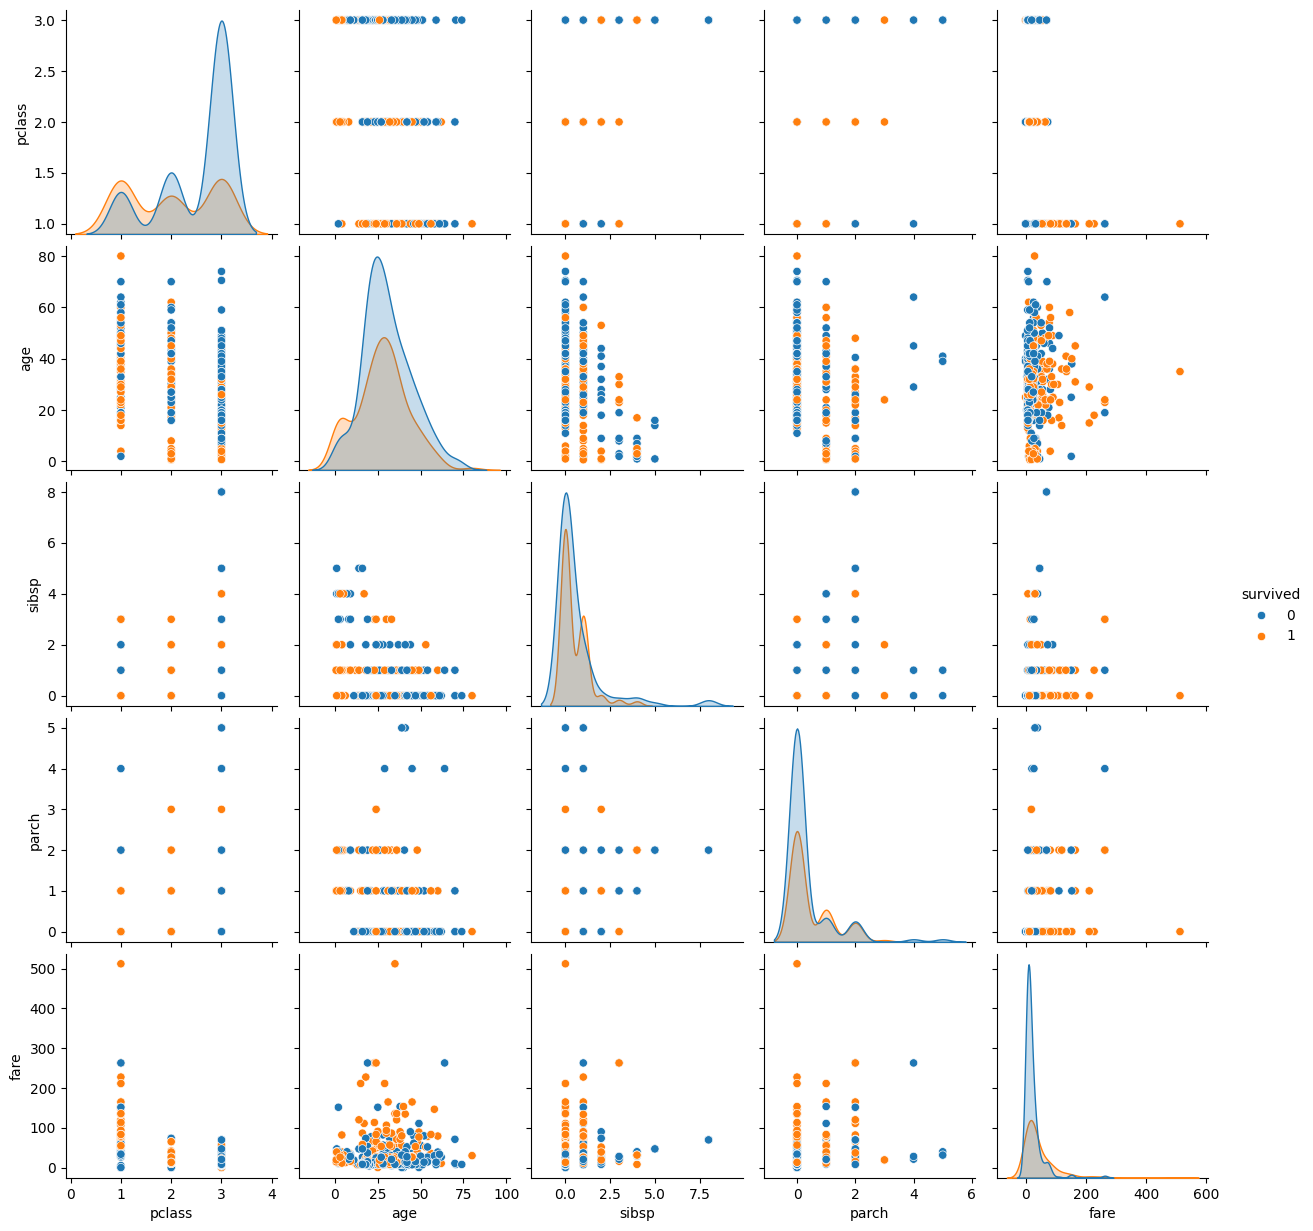

In [25]:
sns.pairplot(df, hue='survived')

In [26]:
(
  df
  .groupby('pclass')
  .fare
  .mean()
)

pclass
1    80.911819
2    21.021025
3    14.033466
Name: fare, dtype: float64

- higher the plcass, higher the fare

### 6. Co-relation analysis

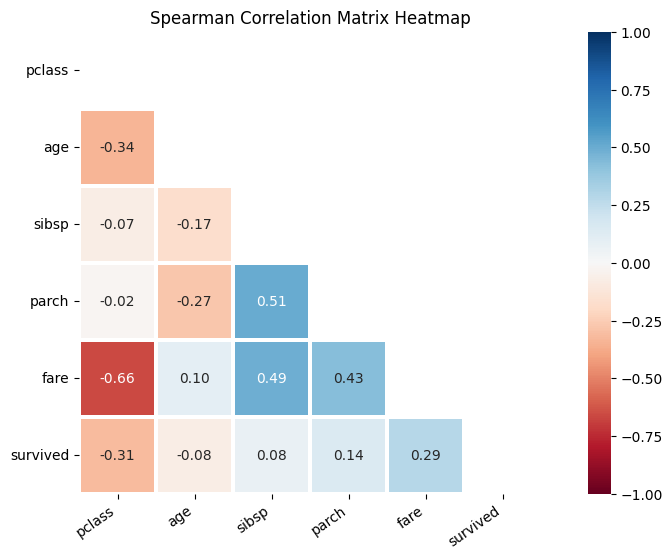

In [27]:
eda_helper_functions.correlation_heatmap(df) # only for numerical features

- pclass has -ve correlation with all features
- higher the number of parents nd children, higher the fare
- parch and sibsp r moderately co-related

In [28]:
(
  df
  .assign(
    fam_size = lambda df_: df_.sibsp + df_.parch
  )
  .drop(columns=['parch', 'sibsp'])
  .groupby('fam_size')
  .survived
  .mean()
)

fam_size
0     0.312500
1     0.512500
2     0.563636
3     0.727273
4     0.000000
5     0.200000
6     0.428571
7     0.000000
10    0.000000
Name: survived, dtype: float64

- family sizes of '2', '3' have higher survival rates

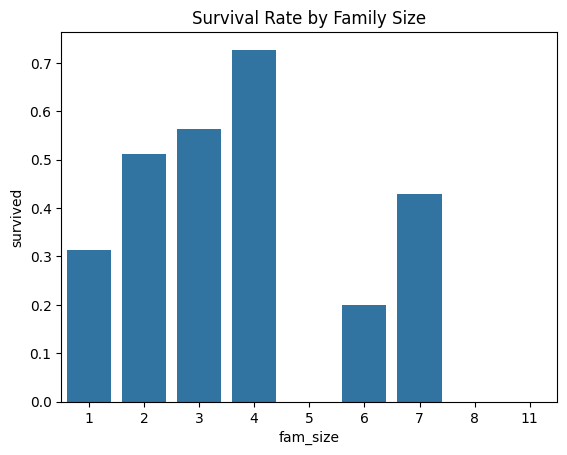

In [29]:
(
    df
    .assign(fam_size = lambda d: d.sibsp + d.parch + 1)   # include self
    .pipe(lambda d: sns.barplot(x="fam_size", y="survived", data=d, errorbar=None))
)
plt.title("Survival Rate by Family Size")
plt.show()

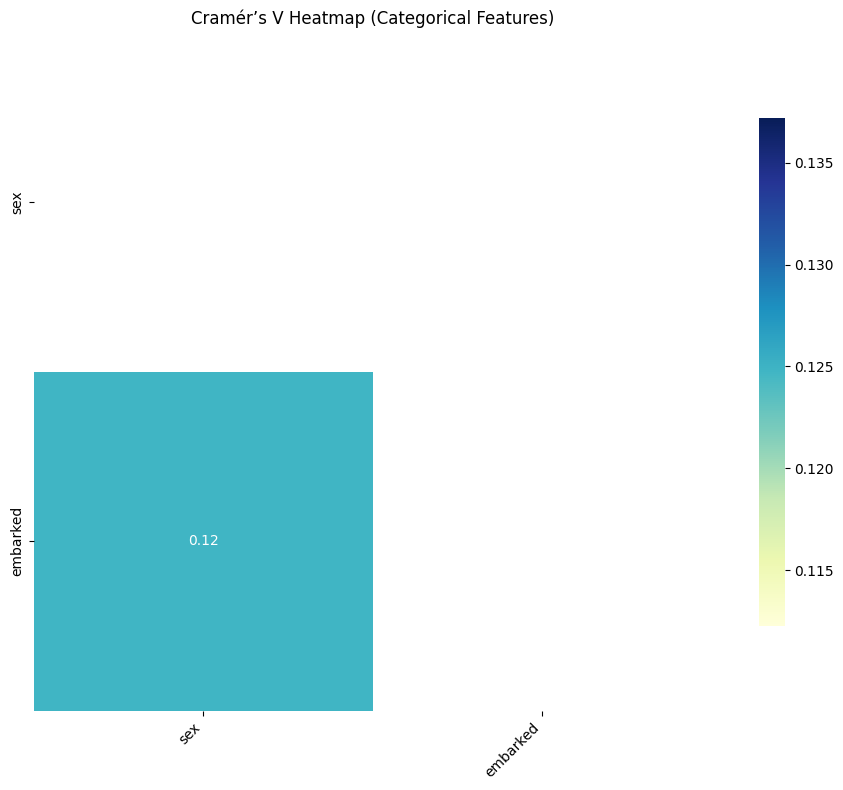

In [30]:
eda_helper_functions.my_plot_cramers_v_heatmap(df)


### 7. Detailed anaylsis (feature wise)

In [32]:
df.columns.tolist()

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']

7.1 `pclass`

In [34]:
df.pclass.value_counts()

pclass
3    279
1    110
2    109
Name: count, dtype: int64

In [35]:
df.pclass.dtype

dtype('int64')

In [38]:
(
 df
 .assign(pclass=df.pclass.astype(object))
 .pipe(lambda d: eda_helper_functions.cat_summary(d, "pclass")) 
)

0      1
1      3
2      3
3      3
4      3
      ..
493    2
494    3
495    2
496    3
497    1
Name: pclass, Length: 498, dtype: object

Data Type      : object
Cardinality    : 3 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 498 / 498 rows


,
count,498
unique,3
top,3
freq,279


,count,percentage
category,,
3,279,0.560241
1,110,0.220884
2,109,0.218876


ValueError: We need at least 1 word to plot a word cloud, got 0.

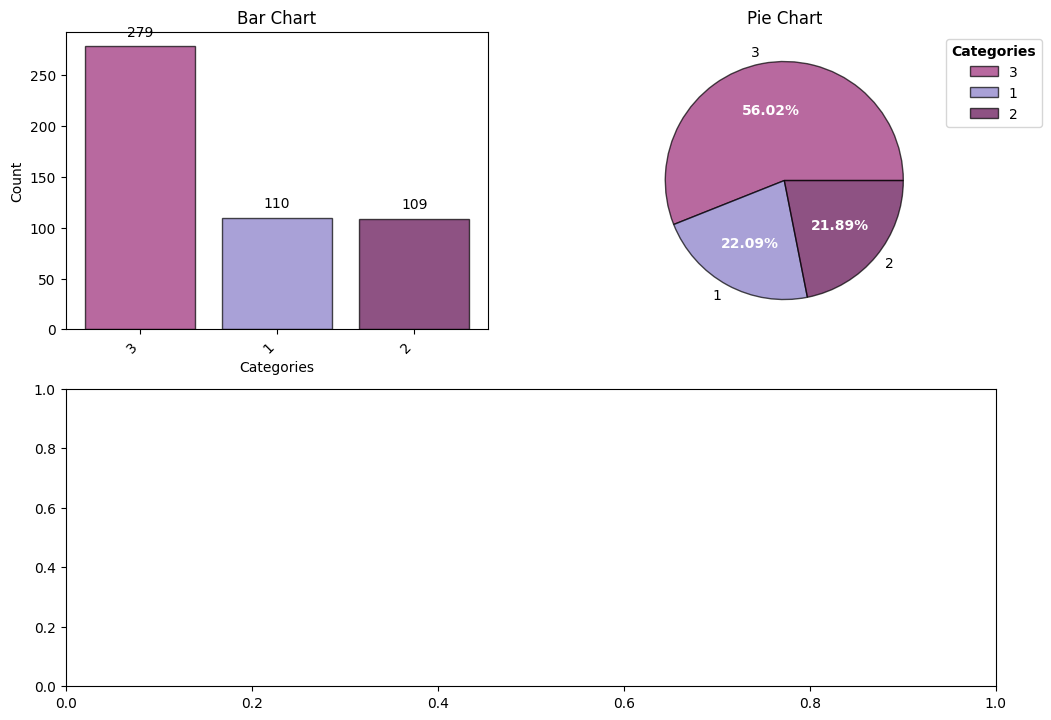

In [44]:
(
  df
  .assign(
    pclass = lambda d: d.pclass.astype('str')
  )
  .pipe(lambda d: eda_helper_functions.cat_univar_plots(d, "pclass"))
)

Observations
 1. `sex` and `embarked` are both imbalanced colms, handle imbalance
 2. `age` and `embarked` have missing values
 3.  see outlier analysis for each colm